# 2022机器学习期末大作业
# 基于VAE的手写数字生成

- 姓名：刘伟  &emsp; &emsp; 张朝阳  &emsp; &emsp; 边笛
- 学号：2013029 &ensp;2011746 &ensp;2012668

### 实验内容
1. 基本要求：利用 pytorch 神经网络框架编程实现变分自编码器 (VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字
2. 中级要求：实现VAE的变分推导，描述VAE的由来以及优缺点
3. 高级要求：实现对VAE进行改进或创新，有VAE的变种——CVAE、β-VAE的实现，可视化方法创新——隐变量输出的实现

### 成员贡献
- 共同部分：学习了解VAE变分自编码器的框架结构，掌握基本的理论前提。
- 刘伟：pytorch构建基本的Dense全连接层VAE；可视化的创新——隐变量层的输出展示；变种——CVAE条件变分自编码器
- 张朝阳：pytorch构建结合Conv卷积层的VAE结构；深入学习VAE的理论推导——复现VAE的变分推导
- 边笛：VAE的变种创新——β-VAE，全面分析β对整个VAE结构的影响并结合隐变量层的学习成果深入分析

# 初级要求
利用 pytorch 神经网络框架编程实现变分自编码器 (VAE)

## 库函数与训练数据的加载

In [2]:
# 导入实验所需的相关库函数
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 下载实验所需的MNIST数据集
train_dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

# 查看mnist数据
print(train_dataset)

# 查看是否支持cuda GPU训练
print(torch.cuda.is_available())

# 数据集切分
batch_size = 128
dataIter = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
True


## 代价损失函数：通过俩种不同的方式构建损失函数

In [4]:
# 展平：多维数据展平成低维数据
def flatten(x):
    N = x.shape[0]  # read in N, C, H, W
    return x.view(N, -1)  # torch.Size([128, 784])


# L2损失 (MSE Loss) 构建损失函数
def vae_loss_mse(x, gen_x, mean, log_var):
    # 重构项损失
    mse_loss = torch.nn.MSELoss(reduction='sum')
    loss1 = mse_loss(gen_x, x)

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss


# 交叉熵损失 (Cross Entropy Loss) 构建损失函数
def vae_loss_cross(x, gen_x, mean, log_var):
    # 重构项损失
    loss1 = F.binary_cross_entropy(gen_x, x, reduction='sum')

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss

## 构造网络模型
- 采用全连接Dense(Linear)设计网络架构
- 采用卷积层Conv+Dense设计网络架构

### 全连接层——VAE网络

In [5]:
class VariationalAutoEncoder_Dense(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 dense_size=(784, 256, 128),
                 z_dim=20):
        super(VariationalAutoEncoder_Dense, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])
        self.enDense1 = nn.Linear(dense_size[1], dense_size[2])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], dense_size[-3])

        # decoder reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 展平
        out = flatten(x)
        # 全连接层
        out = self.relu(self.enDense0(out))
        out = self.relu(self.enDense1(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

### 卷积层——VAE网络

In [6]:
class VariationalAutoEncoder_Conv(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 conv_size=(1, 6, 16, 4),
                 dense_size=(784, 128),
                 kernel=3,
                 z_dim=20):
        super(VariationalAutoEncoder_Conv, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder卷积层
        # 输入 (128,1,28,28) 输出 (128,6,28,28)
        self.enConv0 = nn.Conv2d(conv_size[0], conv_size[1], kernel, padding=1, padding_mode='replicate')
        # 输入 (128,6,28,28) 输出 (128,16,14,14)
        self.enConv1 = nn.Conv2d(conv_size[1], conv_size[2], kernel, stride=2, padding=1, padding_mode='replicate')
        # 输入 (128,16,14,14) 输出 (128,4,14,14)
        self.enConv2 = nn.Conv2d(conv_size[2], conv_size[3], kernel, padding=1, padding_mode='replicate')

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], int(np.prod(image_shape)))

        # 需要对 全连接层输出的一维结果数据 进行 reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 卷积层
        out = self.relu(self.enConv0(x))
        out = self.relu(self.enConv1(out))
        out = self.relu(self.enConv2(out))

        # 展平
        out = flatten(out)

        # 全连接层
        out = self.relu(self.enDense0(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

## 查看网络结构

In [7]:
# 网络训练设备：建议使用cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 利用summary函数查看网络的层次结构
print("==========================VAE(Dense)网络结构==========================")
model_Dense = VariationalAutoEncoder_Dense()
model_Dense.to(device)
summary(model_Dense, input_size=(1, 28, 28))
print("==========================VAE(Conv)网络结构==========================")
model_Conv = VariationalAutoEncoder_Conv()
model_Conv.to(device)
summary(model_Conv, input_size=(1, 28, 28))

cuda
==========================VAE(Dense)网络结构==========================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 20]           2,580
            Linear-6                   [-1, 20]           2,580
            Linear-7                  [-1, 128]           2,688
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 784]         201,488
          Sigmoid-12                  [-1, 784]               0
Total params: 476,216
Trainable

## 设定模型参数

In [8]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 20  # 迭代次数

# 实例化模型 二选一 即可
model = model_Conv
# model = model_Dense

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 模型训练

In [9]:
train_loss = []  # 保存每个epoch的训练误差
number = len(dataIter.dataset)
result_dir = './VAEResult'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = vae_loss_mse(x, gen_x, mean, log_var)
        # loss = vae_loss_cross(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        # 输出batch信息
        # if i % 100 == 0 and i > 0:
        #     print("epoch : {0} | batch : {1} | batch average loss: {2}"
        #           .format(epoch + 1, i, loss.item() / x.shape[0]))

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])
        #     save_image(x_concatD, './%s/reconstructed-%d.png' % (result_dir, epoch + 1))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

epoch[1/20] | loss:52.37612461751302
epoch[2/20] | loss:38.15426111653646
epoch[3/20] | loss:33.8532580485026
epoch[4/20] | loss:32.30478760986328
epoch[5/20] | loss:31.240277282714842
epoch[6/20] | loss:30.621502152506512
epoch[7/20] | loss:30.20562481689453
epoch[8/20] | loss:29.88453271077474
epoch[9/20] | loss:29.626651607259113
epoch[10/20] | loss:29.438368599446616
epoch[11/20] | loss:29.267931953938803
epoch[12/20] | loss:29.087553869628906
epoch[13/20] | loss:28.97938673502604
epoch[14/20] | loss:28.863276033528646
epoch[15/20] | loss:28.741947403971356
epoch[16/20] | loss:28.638105383300783
epoch[17/20] | loss:28.515713920084636
epoch[18/20] | loss:28.441164237467447
epoch[19/20] | loss:28.351834224446616
epoch[20/20] | loss:28.28068007405599


## 展示最终迭代训练后：VAE生成图片与原始图片的对比

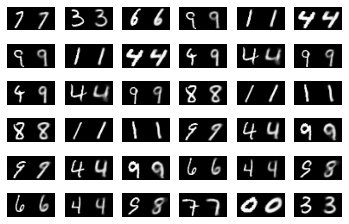

In [10]:
# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

## evaluation 测试生成效果

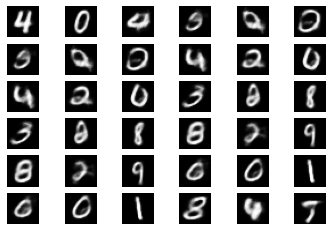

In [11]:
# 从正态分布随机采样z
z = torch.randn((batch_size, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.
# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

# 中级要求

## 实现VAE的变分推导

<img src="https://github.com/ZhaoYang0125/src/blob/main/vae1.jpg?raw=true" alt="vae1" style="zoom:45%;" />
<img src="https://github.com/ZhaoYang0125/src/blob/main/vae2.jpg?raw=true" alt="vae2" style="zoom:45%;" />

## VAE的由来以及优缺点

自编码器（Auto-Encoder，AE）是一种无监督的神经网络，一般由编码器和解码器两部分构成。其过程为：编码器处理输入的数据进行编码，解码器根据编码内容来解码，从而还原出原始输入数据。简单来说，就是输入即为输出。这样的过程当然存在一定的问题：
* 容易受噪声数据干扰
* 对于没见过的输入，会给出意料之外的输出
* 以原输入再生成出原输入，在实际操作中，并无太大用处。
    
为了克服上述缺点，人们提出了一些AE模型的变种方案，VAE就是一种AE的变种。 

变分自编码器（Variational AutoEncoder，VAE），是一个根据输入的数据的分布，类型，来模拟生成类似于输入数据的数据生成模型。VAE结合贝叶斯理论，不再认为整个样本空间只服从一个可观测的概率分布，而认为存在一个隐变量`z`​​，控制着每个样本的概率分布。在隐变量`z`的作用下，VAE的输出不再与输入相同，而是成为了输入的一个近似，存在更多的不确定性。这样的结果是一把双刃剑：

* 优点：VAE采用分布的形式使得输出更加多样化，且不同的输出结果之间连接比较平滑。可以处理各种类型的数据，序列的和非序列的，连续的或离散的，甚至有标签的或无标签的，这使得它成为非常强大的生成工具。
* 缺点：生成的输出比较模糊，甚至可能偏离输入内容较远。不适用于对结果精确度有较高要求的情景。

# 高级要求

## 隐变量输出展示

为了便于得知隐变量的学习内容，将z_dim改成2维，进行训练学习，观察隐变量采样

epoch[1/20] | loss:54.73777405598958
epoch[2/20] | loss:48.60477434082031
epoch[3/20] | loss:41.396358451334635
epoch[4/20] | loss:39.77705034586589
epoch[5/20] | loss:38.7182927734375
epoch[6/20] | loss:38.03185735270182
epoch[7/20] | loss:37.55494031575521
epoch[8/20] | loss:37.23315347086589
epoch[9/20] | loss:36.958701883951825
epoch[10/20] | loss:36.75901299641927
epoch[11/20] | loss:36.58999401041667
epoch[12/20] | loss:36.450571240234375
epoch[13/20] | loss:36.328932267252604
epoch[14/20] | loss:36.19714766438802
epoch[15/20] | loss:36.11057159423828
epoch[16/20] | loss:35.986125130208336
epoch[17/20] | loss:35.932440087890626
epoch[18/20] | loss:35.844634948730466
epoch[19/20] | loss:35.799882779947914
epoch[20/20] | loss:35.727352176920576


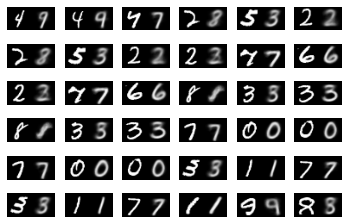

In [12]:
import os
from scipy.stats import norm

# 生成隐空间内的采样
# 训练时Z_dim设定为20，这里仅观察隐空间前俩维度表示特征
model = VariationalAutoEncoder_Conv(z_dim=2)
model.to(device)
epoches = 20
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []  # 保存每个epoch的训练误差
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = vae_loss_mse(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

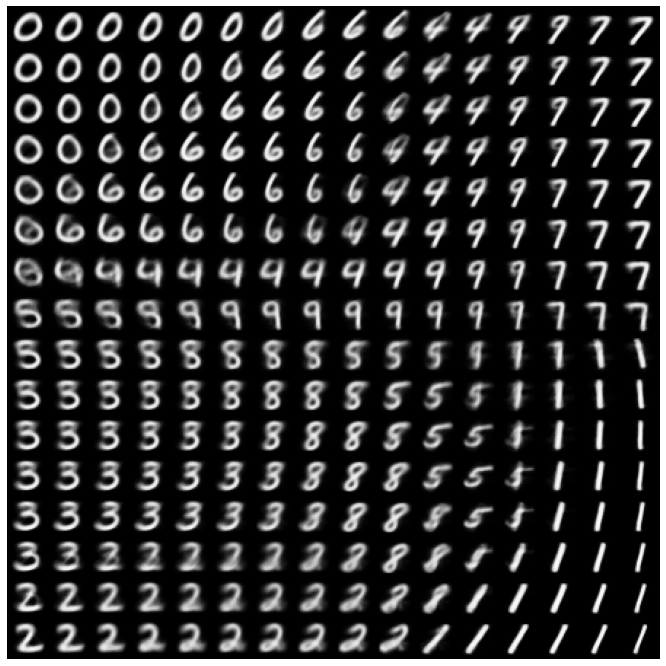

In [13]:
num_per_row, num_per_col = 16, 16
digit_size = 28
figure = np.zeros((digit_size * num_per_row, digit_size * num_per_col))
grid_x = norm.ppf(np.linspace(0.05, 0.95, num_per_row))
grid_y = norm.ppf(np.linspace(0.05, 0.95, num_per_col))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.tensor(np.tile(z_sample, batch_size).reshape(batch_size, 2)).to(device).to(torch.float32)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        digit = torch.sigmoid(digit)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit.detach().cpu().numpy() * 255.

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()

### 从上图中可以看出，VAE学到的二维隐变量Z:
- 第一维度（水平维度）主要控制`数字的形状`，字体的斜度改变幅度不大
- 第二维度（竖直维度）主要控制数字的`倾斜`和`形状（低于第一维度的影响）`

## CVAE

### 先介绍AE和VAE的优缺点：
- AE适合数据压缩与还原，不适合生成未见过的数据
- VAE适合生成未见过的数据，但不能控制生成内容。
### CVAE（Conditional VAE）可以在生成数据时通过指定其标签来生成想生成的数据

<img src="https://img2020.cnblogs.com/blog/2226924/202104/2226924-20210424093924301-1328423376.jpg"  alt="ImageFile" style="zoom:50%;"/>


In [14]:
# 条件变分自编码器
class CVAE(nn.Module):

    def __init__(self, feature_size, class_size, latent_size):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(feature_size + class_size, 200)
        self.fc2_mu = nn.Linear(200, latent_size)
        self.fc2_log_std = nn.Linear(200, latent_size)
        self.fc3 = nn.Linear(latent_size + class_size, 200)
        self.fc4 = nn.Linear(200, feature_size)

    def encode(self, x, y):
        h1 = F.relu(self.fc1(torch.cat([x, y], dim=1)))  # 连接特征和标签
        mu = self.fc2_mu(h1)
        log_std = self.fc2_log_std(h1)
        return mu, log_std

    def decode(self, z, y):
        h3 = F.relu(self.fc3(torch.cat([z, y], dim=1)))  # 连接标签和latent隐变量
        recon = torch.sigmoid(self.fc4(h3))
        return recon

    def reparametrize(self, mu, log_std):
        std = torch.exp(0.5 * log_std)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, y):
        mu, log_std = self.encode(x, y)
        z = self.reparametrize(mu, log_std)
        recon = self.decode(z, y)
        return recon, mu, log_std

    def loss_function(self, recon, x, mu, log_std) -> torch.Tensor:
        recon_loss = F.mse_loss(recon, x, reduction="sum")
        kl_loss = -0.5 * (1 + 2 * log_std - mu.pow(2) - torch.exp(2 * log_std))
        kl_loss = torch.sum(kl_loss)
        loss = recon_loss + kl_loss
        return loss

In [16]:
cvae = CVAE(feature_size=784, class_size=10, latent_size=20)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)
result_dir = '.\\VAEResult\\CVAE'

train_loss = []
epoches = 40
for epoch in range(epoches):

    batch_loss = []
    for i, data in enumerate(dataIter):
        img, label = data
        img.to(device)
        inputs = img.view(img.shape[0], -1)
        y = torch.nn.functional.one_hot(label, num_classes=10)
        # print(inputs.shape)
        # print(y.shape)
        y.to(device)

        recon, mu, log_std = cvae(inputs, y)
        loss = cvae.loss_function(recon, inputs, mu, log_std)
        batch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 输出batch信息
        if i % 100 == 0 and i > 0:
            print("epoch : {0} | batch : {1} | batch average loss: {2}"
                  .format(epoch + 1, i, loss.item() / img.shape[0]))
        if i == 0:
            x_concatD = torch.cat([img.view(-1, 1, 28, 28), recon.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concatD, '%s\\reconstructed-%d.png' % (result_dir, epoch + 1))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

epoch : 1 | batch : 100 | batch average loss: 51.963008880615234
epoch : 1 | batch : 200 | batch average loss: 45.13134002685547
epoch : 1 | batch : 300 | batch average loss: 40.94240188598633
epoch : 1 | batch : 400 | batch average loss: 38.570213317871094
epoch[1/40] | loss:48.95314457194011
epoch : 2 | batch : 100 | batch average loss: 38.26136016845703
epoch : 2 | batch : 200 | batch average loss: 37.370811462402344
epoch : 2 | batch : 300 | batch average loss: 35.45708084106445
epoch : 2 | batch : 400 | batch average loss: 35.08346176147461
epoch[2/40] | loss:36.59286827799479
epoch : 3 | batch : 100 | batch average loss: 36.25738525390625
epoch : 3 | batch : 200 | batch average loss: 33.35258865356445
epoch : 3 | batch : 300 | batch average loss: 32.806697845458984
epoch : 3 | batch : 400 | batch average loss: 33.62622833251953
epoch[3/40] | loss:34.4992719523112
epoch : 4 | batch : 100 | batch average loss: 34.40482711791992
epoch : 4 | batch : 200 | batch average loss: 34.58514

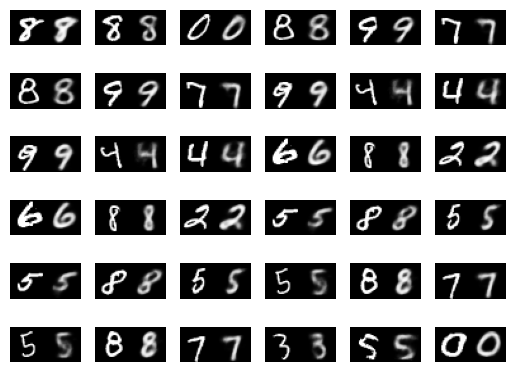

In [17]:
# 展示最终迭代训练后：VAE生成图片与原始图片的对比
x_s = x_concatD.view(128, 28, 56).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_s[i * 3 + j], cmap='gray')
plt.show()

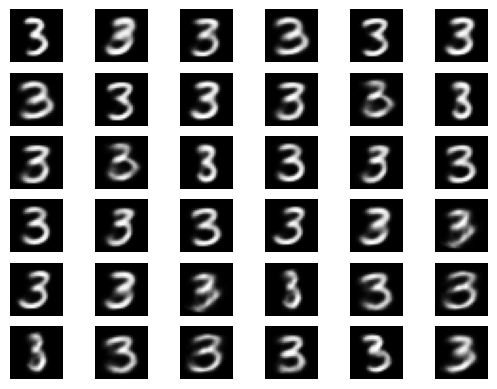

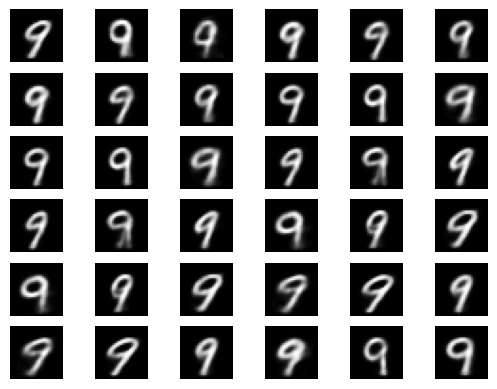

In [18]:
# 利用CVAE生成特定label下的图片
label = 3
z = torch.randn(784, 20)
labels = torch.full(size=(784,), fill_value=label, dtype=torch.int64)
y = torch.nn.functional.one_hot(labels, num_classes=10)
recon = cvae.decode(z, y)

# 显示
img = recon.view(recon.shape[0],  28, 28).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(img[i * 3 + j], cmap='gray')
plt.show()

label = 9
z = torch.randn(784, 20)
labels = torch.full(size=(784,), fill_value=label, dtype=torch.int64)
y = torch.nn.functional.one_hot(labels, num_classes=10)
recon = cvae.decode(z, y)

# 显示
img = recon.view(recon.shape[0],  28, 28).detach().cpu().numpy() * 255.
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(img[i * 3 + j], cmap='gray')
plt.show()

## β-VAE


### β-VAE是在传统VAE基础上对损失函数进行修改，为损失函数的KL散度项加上一个超参数β

VAE的损失函数由两部分组成，一部分是重构项，一部分是KL散度。VAE的整体过程可以粗略看成两步，第一步是编码，第二步是解码，两步由编码生成的隐变量连结。β的引入相当于为隐变量的信息增加了一个信息瓶颈。

重构项反映了输入与隐变量的互信息大小，KL部分反映了隐变量含有的信息量大小，β的引入约束了隐变量的传递的信息量，在信息保存（重建成本作为正则化）和潜在信道容量限制（β>1）之间寻找平衡，增强了模型的解耦能力。

#### 损失函数引入超参数β

In [19]:
# L2损失 (MSE Loss) 构建损失函数
def beta_vae_loss_mse(x, gen_x, mean, log_var, beta):
    # 重构项损失
    mse_loss = torch.nn.MSELoss(reduction='sum')
    loss1 = mse_loss(gen_x, x)

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + beta*KL_loss
    

# 交叉熵损失 (Cross Entropy Loss) 构建损失函数
def beta_vae_loss_cross(x, gen_x, mean, log_var, beta):
    # 重构项损失
    loss1 = F.binary_cross_entropy(gen_x, x, reduction='sum')

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + beta*KL_loss

In [20]:
test_z = torch.randn((batch_size, 20)).to(device)

经测试 β = 3 时有较好的生成效果

epoch[1/10] | loss:53.801485278320314
epoch[2/10] | loss:48.48496276855469
epoch[3/10] | loss:46.122619482421875
epoch[4/10] | loss:44.91053746744792
epoch[5/10] | loss:44.41830204264323
epoch[6/10] | loss:44.05171790364583
epoch[7/10] | loss:43.800046158854165
epoch[8/10] | loss:43.617858894856774
epoch[9/10] | loss:43.45289364420573
epoch[10/10] | loss:43.37656237792969


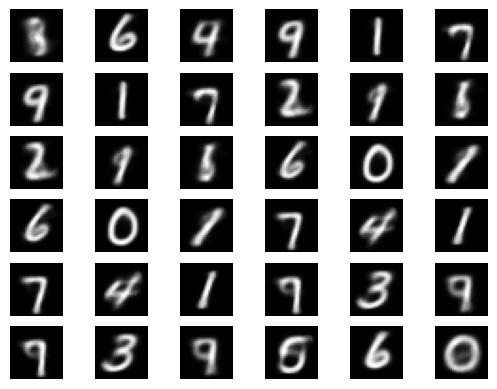

In [21]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型
beta_vae = VariationalAutoEncoder_Conv()
beta_vae.to(device)
beta_model = beta_vae

#超参数
beta = 3

# 创建优化器
beta_optimizer = torch.optim.Adam(beta_model.parameters(), lr=learning_rate)

train_loss = []  # 保存每个epoch的训练误差
result_dir = '.\\VAEResult\\bata-VAE'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        
        mean, log_var, gen_x = beta_model(x)
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, beta)
        batch_loss.append(loss.item())

        # 反向传播和优化
        beta_optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        beta_optimizer.step()  # 梯度下降

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)], dim=3)
    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

logits = beta_model.decode(test_z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.

# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

###  为进一步探究验证超参数β的作用，测试不同β值下的生成结果

β = 1 (VAE)

epoch[1/10] | loss:49.908536385091146
epoch[2/10] | loss:36.818755301920575
epoch[3/10] | loss:33.74037689208984
epoch[4/10] | loss:32.548841548665365
epoch[5/10] | loss:31.865619213867188
epoch[6/10] | loss:31.306879956054686
epoch[7/10] | loss:30.82028231608073
epoch[8/10] | loss:30.462920483398438
epoch[9/10] | loss:30.15816045735677
epoch[10/10] | loss:29.915357299804686


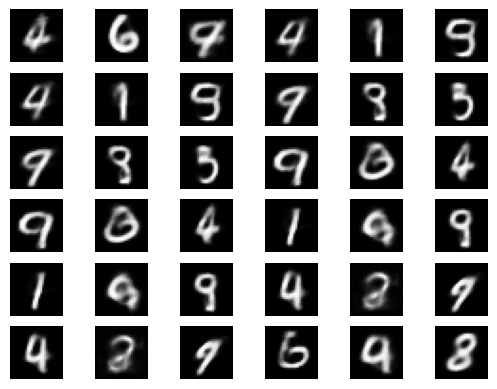

In [22]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型
beta_vae1 = VariationalAutoEncoder_Conv()
beta_vae1.to(device)
beta_model = beta_vae1

#超参数
beta = 1

# 创建优化器
beta_optimizer = torch.optim.Adam(beta_model.parameters(), lr=learning_rate)

train_loss = []  # 保存每个epoch的训练误差
result_dir = '.\\VAEResult\\bata-VAE'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        
        mean, log_var, gen_x = beta_model(x)
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, beta)
        batch_loss.append(loss.item())

        # 反向传播和优化
        beta_optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        beta_optimizer.step()  # 梯度下降
        
        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)], dim=3)

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))


logits = beta_model.decode(test_z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.

# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

β = 8

epoch[1/10] | loss:54.8489836344401
epoch[2/10] | loss:52.94638594563802
epoch[3/10] | loss:52.85733248697917
epoch[4/10] | loss:52.76279864095052
epoch[5/10] | loss:52.70004223632812
epoch[6/10] | loss:52.665559692382814
epoch[7/10] | loss:52.62776123046875
epoch[8/10] | loss:52.4991755859375
epoch[9/10] | loss:52.44217868652344
epoch[10/10] | loss:52.42447747395833


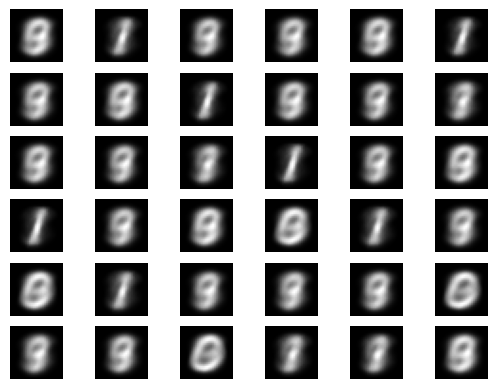

In [23]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型
beta_vae2 = VariationalAutoEncoder_Conv()
beta_vae2.to(device)
beta_model = beta_vae2

#超参数
beta = 8

# 创建优化器
beta_optimizer = torch.optim.Adam(beta_model.parameters(), lr=learning_rate)

train_loss = []  # 保存每个epoch的训练误差
result_dir = '.\\VAEResult\\bata-VAE'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        
        mean, log_var, gen_x = beta_model(x)
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, beta)
        batch_loss.append(loss.item())

        # 反向传播和优化
        beta_optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        beta_optimizer.step()  # 梯度下降

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)], dim=3)
    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

logits = beta_model.decode(test_z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.

# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

β = 16

epoch[1/10] | loss:54.87018264160156
epoch[2/10] | loss:52.99105546875
epoch[3/10] | loss:52.91904027506511
epoch[4/10] | loss:52.876090885416666
epoch[5/10] | loss:52.853292586263024
epoch[6/10] | loss:52.82928025716146
epoch[7/10] | loss:52.80811359049479
epoch[8/10] | loss:52.7967451578776
epoch[9/10] | loss:52.78326774902344
epoch[10/10] | loss:52.77977409667969


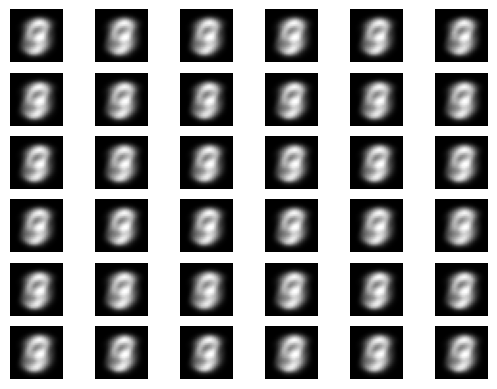

In [24]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型
beta_vae3 = VariationalAutoEncoder_Conv()
beta_vae3.to(device)
beta_model = beta_vae3

#超参数
beta = 16

# 创建优化器
beta_optimizer = torch.optim.Adam(beta_model.parameters(), lr=learning_rate)

train_loss = []  # 保存每个epoch的训练误差
result_dir = '.\\VAEResult\\bata-VAE'  # 保存生成图片的目录
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        
        mean, log_var, gen_x = beta_model(x)
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, beta)
        batch_loss.append(loss.item())

        # 反向传播和优化
        beta_optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        beta_optimizer.step()  # 梯度下降

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)], dim=3)
    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

logits = beta_model.decode(test_z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.

# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()

经过测试发现，随着β的增大生成的手写数字特征逐渐单一，可以推断出是由于隐变量信息保留的过少导致的。

### 为进一步验证，对于不同β下学习得到的隐变量进行观察

β = 3

epoch[1/15] | loss:53.993572607421875
epoch[2/15] | loss:48.99080161946615
epoch[3/15] | loss:47.26605036621094
epoch[4/15] | loss:46.69642425130208
epoch[5/15] | loss:46.279779052734376
epoch[6/15] | loss:45.92567962239583
epoch[7/15] | loss:45.71086240234375
epoch[8/15] | loss:45.59258842773438
epoch[9/15] | loss:45.46363501790365
epoch[10/15] | loss:45.325813842773435
epoch[11/15] | loss:45.29882972819011
epoch[12/15] | loss:45.17237499186198
epoch[13/15] | loss:45.110591959635414
epoch[14/15] | loss:45.02343063964844
epoch[15/15] | loss:45.03124555664063


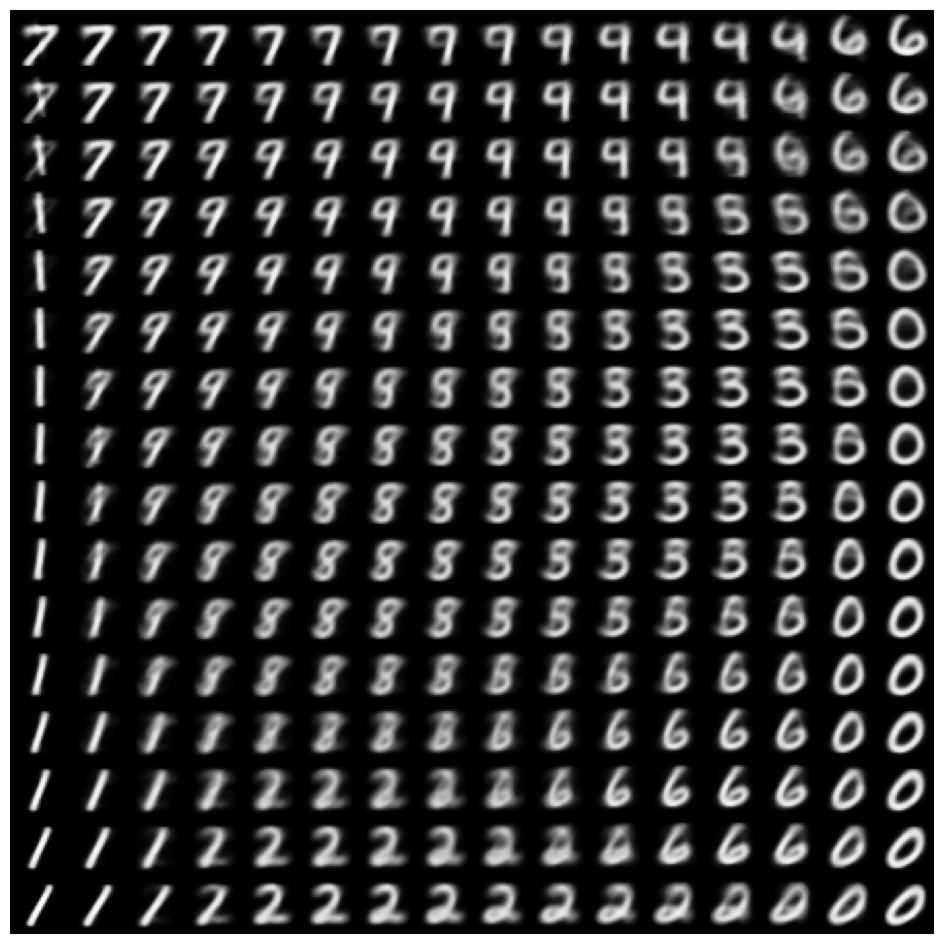

In [25]:
import os
from scipy.stats import norm

# 生成隐空间内的采样
# 训练时Z_dim设定为20，这里仅观察隐空间前俩维度表示特征
model = VariationalAutoEncoder_Conv(z_dim=2)
model.to(device)
epoches = 15
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []  # 保存每个epoch的训练误差
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, 3)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

num_per_row, num_per_col = 16, 16
digit_size = 28
figure = np.zeros((digit_size * num_per_row, digit_size * num_per_col))
grid_x = norm.ppf(np.linspace(0.05, 0.95, num_per_row))
grid_y = norm.ppf(np.linspace(0.05, 0.95, num_per_col))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.tensor(np.tile(z_sample, batch_size).reshape(batch_size, 2)).to(device).to(torch.float32)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        digit = torch.sigmoid(digit)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit.detach().cpu().numpy() * 255.

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()

β = 8

epoch[1/15] | loss:54.59007465820312
epoch[2/15] | loss:52.874010213216145
epoch[3/15] | loss:52.84616063639323
epoch[4/15] | loss:52.82879040527344
epoch[5/15] | loss:52.81733885091146
epoch[6/15] | loss:52.79720810546875
epoch[7/15] | loss:52.792586328125
epoch[8/15] | loss:52.78499647623698
epoch[9/15] | loss:52.777526326497394
epoch[10/15] | loss:52.77128342285156
epoch[11/15] | loss:52.76522055664063
epoch[12/15] | loss:52.76194845377604
epoch[13/15] | loss:52.75534208984375
epoch[14/15] | loss:52.75855578613281
epoch[15/15] | loss:52.755916861979166


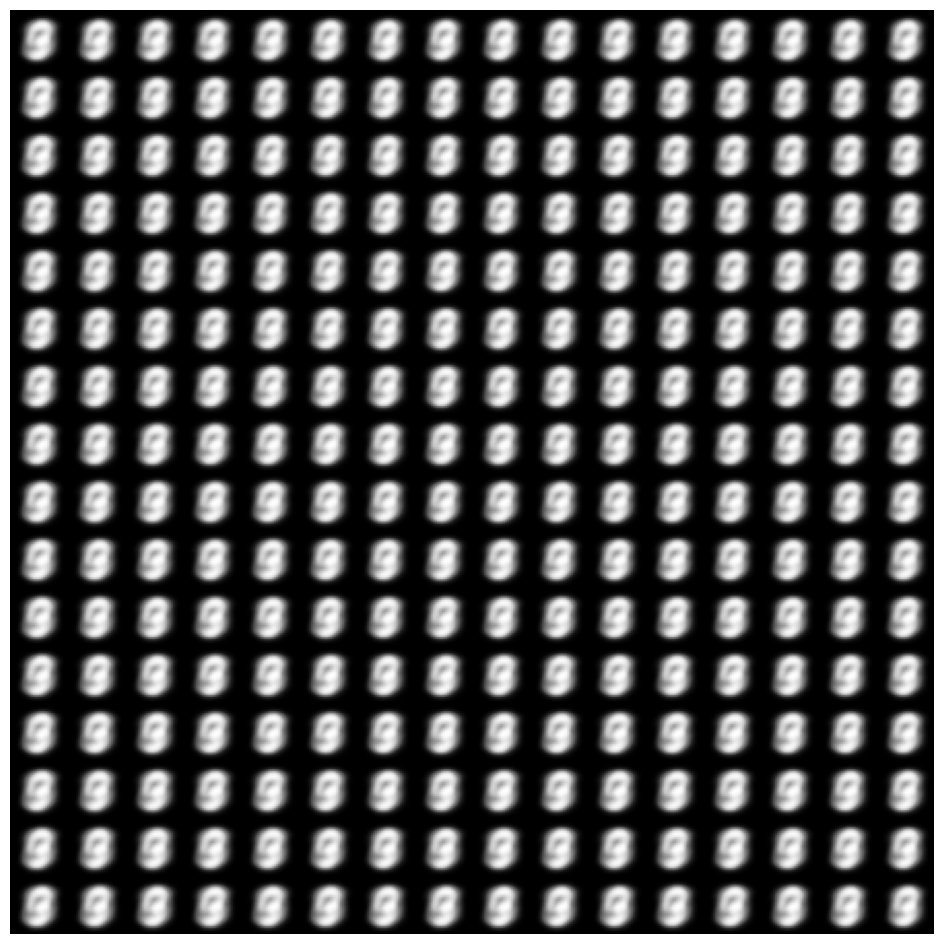

In [26]:
import os
from scipy.stats import norm

# 生成隐空间内的采样
# 训练时Z_dim设定为20，这里仅观察隐空间前俩维度表示特征
model = VariationalAutoEncoder_Conv(z_dim=2)
model.to(device)
epoches = 15
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []  # 保存每个epoch的训练误差
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, 8)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

num_per_row, num_per_col = 16, 16
digit_size = 28
figure = np.zeros((digit_size * num_per_row, digit_size * num_per_col))
grid_x = norm.ppf(np.linspace(0.05, 0.95, num_per_row))
grid_y = norm.ppf(np.linspace(0.05, 0.95, num_per_col))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.tensor(np.tile(z_sample, batch_size).reshape(batch_size, 2)).to(device).to(torch.float32)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        digit = torch.sigmoid(digit)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit.detach().cpu().numpy() * 255.

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()

β = 16

epoch[1/15] | loss:54.63142722167969
epoch[2/15] | loss:52.87429535319011
epoch[3/15] | loss:52.84610010579427
epoch[4/15] | loss:52.8118392171224
epoch[5/15] | loss:52.809633618164064
epoch[6/15] | loss:52.79538573404948
epoch[7/15] | loss:52.79316895345052
epoch[8/15] | loss:52.78191050618489
epoch[9/15] | loss:52.766322029622394
epoch[10/15] | loss:52.767954125976566
epoch[11/15] | loss:52.767016292317706
epoch[12/15] | loss:52.75978400065104
epoch[13/15] | loss:52.756106754557294
epoch[14/15] | loss:52.75557743326823
epoch[15/15] | loss:52.749213810221356


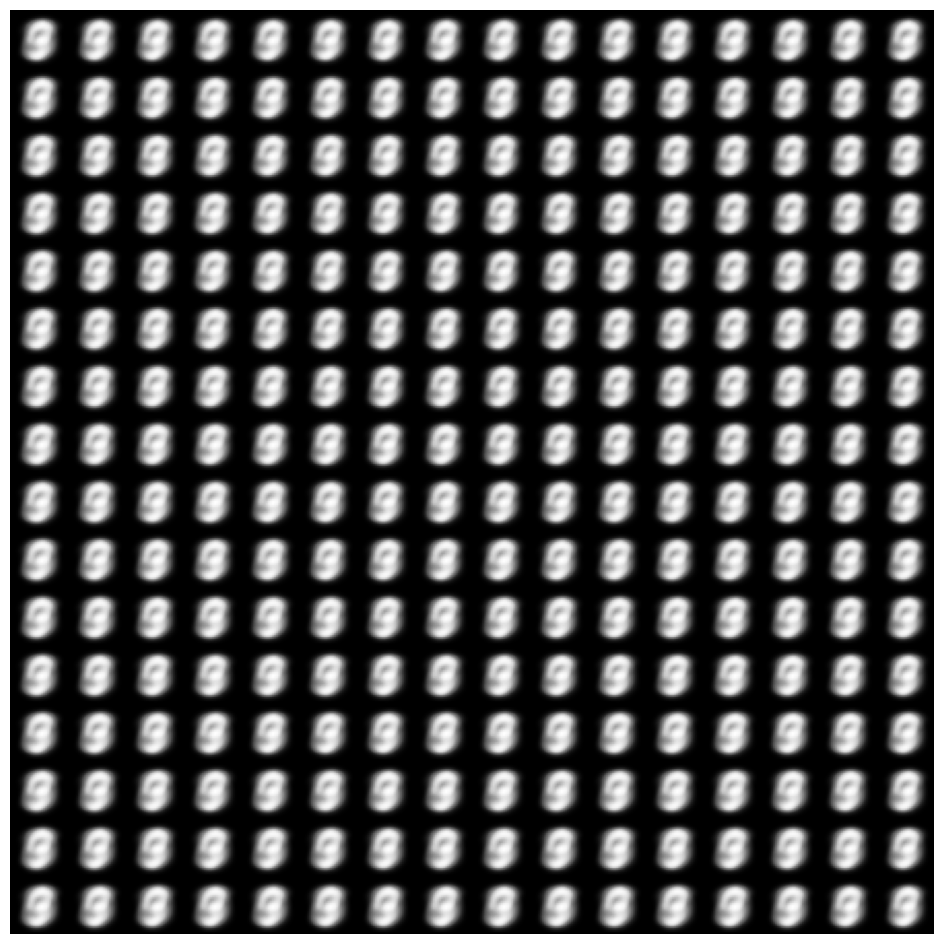

In [27]:
import os
from scipy.stats import norm

# 生成隐空间内的采样
# 训练时Z_dim设定为20，这里仅观察隐空间前俩维度表示特征
model = VariationalAutoEncoder_Conv(z_dim=2)
model.to(device)
epoches = 15
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []  # 保存每个epoch的训练误差
x_concatD = torch.empty((128, 1, 28, 56))

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = beta_vae_loss_mse(x, gen_x, mean, log_var, 16)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)],
                                  dim=3)  #torch.Size([128, 1, 28, 56])

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

num_per_row, num_per_col = 16, 16
digit_size = 28
figure = np.zeros((digit_size * num_per_row, digit_size * num_per_col))
grid_x = norm.ppf(np.linspace(0.05, 0.95, num_per_row))
grid_y = norm.ppf(np.linspace(0.05, 0.95, num_per_col))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = torch.tensor(np.tile(z_sample, batch_size).reshape(batch_size, 2)).to(device).to(torch.float32)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        digit = torch.sigmoid(digit)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit.detach().cpu().numpy() * 255.

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(figure, cmap='Greys_r')
plt.show()

很明显可以看到随着β的增大，隐变量所蕴含信息的减少，更加印证了β引入的作用。

将标准的VAE框架重新设计为 具有强大潜在容量约束和独立先验压力的约束优化问题。通过用可调节此类压力强度的β系数增加下界公式，并因此提高模型所体现的定性性质，β-VAE能够一致而稳健地发现数据中更多的变异因素，并且它学习的表示形式涵盖了更广泛的因子值范围，并且比其他基准测试更清晰地进行了纠缠.。